In [38]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
import torchvision.transforms as T
from utils.import_data import WiderFaceDataset, TRANSFORM, TRAIN_ROOT, TRAIN_ANN_FILE, TEST_ROOT
from utils.anchors import AnchorMatcher, AnchorGenerator, box_nms, compute_loss_with_anchors


# Create the dataset
dataset = WiderFaceDataset(
    root_dir=TRAIN_ROOT, 
    annotation_file=TRAIN_ANN_FILE, 
    img_size=224, 
    transform=TRANSFORM,
    single_face_only=True #if true, thirds the total images
    )

print(f"Total images: {len(dataset)}")

#custom collate function to seperate the boxes from the images
def custom_collate_fn(batch):
    images, targets = zip(*batch)  # unzip the batch
    return images, targets

# Create a dataloader
dataloader = DataLoader(
    dataset, 
    batch_size=64, #64 runs quicest on desktop
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    #use collate here because our data has the images but also the boxes and number of boxes
    collate_fn = custom_collate_fn
    )



Total images: 4631


In [ ]:
class FaceDetectionNet(nn.Module):
    def __init__(self, num_anchors=1):
        """
        num_anchors: number of boxes predicted per spatial cell (simplest: 1)
        kernel_size is the size of the box we pass over each img to extract the features, exactly like tf (3,3,3)
        """
        super(FaceDetectionNet, self).__init__()

        #Backbone (feature extractor)
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # RGB input
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # downsample by 2 -> 112x1112

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # downsample by 2 -> 56x56

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # downsample by 2 -> 28x28
        )

        # Detection head
        # Predict bounding boxes + confidence
        # Output channels = num_anchors * 5 (x, y, w, h, conf)
        self.det_head = nn.Conv2d(256, num_anchors * 5, kernel_size=1)

    def forward(self, x):
        """
        x: [batch_size, 3, H, W]
        Returns:
            out: [batch_size, num_anchors * 5, H/4, W/4] 
                 Each cell predicts (x, y, w, h, confidence)
        """
        features = self.backbone(x)
        out = self.det_head(features)  # [B, 5*num_anchors, H', W']

        B, C, H, W = out.shape
        out = out.view(B, -1, 5, H, W)  # [B, num_anchors, 5, H', W']
        return out

In [26]:
import time
net = FaceDetectionNet()

#moves all the info to the gpu (cuda) if it can, if not it keeps it on the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}") 
net = net.to(device)


optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
scaler = GradScaler()

# Initialize anchor generator and matcher
anchor_gen = AnchorGenerator(scales=[1.0], aspect_ratios=[1.0])
matcher = AnchorMatcher(pos_iou_thresh=0.5, neg_iou_thresh=0.4)
# Generate anchors (assuming feature map is 28x28 after 2x2 pooling)
anchors = anchor_gen.generate_anchors(feature_h=28, feature_w=28, stride=8, img_size=224)

start_epoch = 0
num_epochs = 100
checkpoint_rate = 20

loadLastCheckpoint = True
if loadLastCheckpoint:
    # Check for existing checkpoints and load the latest one
    checkpoint_files = [f for f in os.listdir("checkpoints") if f.startswith("faceNet_checkpoint")]
    if checkpoint_files:
        # Sort by epoch number and get the latest
        latest_checkpoint = sorted(checkpoint_files, key=lambda x: int(x.split('checkpoint')[1].split('.')[0]))[-1]
        checkpoint_path = os.path.join("checkpoints", latest_checkpoint)
        
        checkpoint = torch.load(checkpoint_path, map_location=device)
        net.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        start_epoch = checkpoint["epoch"] + 1
        print(f"Loaded checkpoint from epoch {checkpoint['epoch'] + 1}")

timer_start = time.time()
for epoch in range(start_epoch, num_epochs):
    net.train() # sets the net to training mode
    epoch_loss = 0

    #with pytorch it wont let you pass the entire dataset to the net at once so you have to send it in batches (thats what the batch size is for)
    for images, targets in dataloader:
        # images is a tuple of tensors; stack into a single batch tensor
        images = torch.stack(images).to(device)    # shape: [batch_size, 3, 224, 224]
        boxes = [t['boxes'].to(device) for t in targets]  # move each image's boxes to GPU

        optimizer.zero_grad()               # resets gradients
        # outputs = net(images)               # forward pass
        # loss = compute_loss_with_anchors(outputs, boxes, anchors, matcher, device)
        # loss.backward()                     # backpropogation
        # optimizer.step()                    # update weights 

        with autocast('cuda'):  # Use FP16 for forward pass
            outputs = net(images)
            loss = compute_loss_with_anchors(outputs, boxes, anchors, matcher, device)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += loss.item()  # accumulate batch loss

    #timer to see how long each epoch takes
    timer_end = time.time()
    length = timer_end-timer_start
    mins, secs = divmod(length, 60)

    #custom loss to mimic what it looks like in tf
    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {avg_epoch_loss:.4f} - Time taken: 0{int(mins)}:{secs:.2f}")
    timer_start = time.time()

    #saves a checkpoint
    if (epoch+1) % checkpoint_rate == 0:
        torch.save({
            "epoch": epoch,
            "model_state": net.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "loss": avg_epoch_loss
        }, f"checkpoints/faceNet_checkpoint{epoch+1}.pth")






Training on: cuda
Loaded checkpoint from epoch 45
Epoch [46/100] - Average Loss: 0.1537 - Time taken: 01:4.90
Epoch [47/100] - Average Loss: 0.1514 - Time taken: 01:4.74
Epoch [48/100] - Average Loss: 0.1495 - Time taken: 01:4.57
Epoch [49/100] - Average Loss: 0.1465 - Time taken: 01:4.89
Epoch [50/100] - Average Loss: 0.1458 - Time taken: 01:8.84
Epoch [51/100] - Average Loss: 0.1455 - Time taken: 01:9.08
Epoch [52/100] - Average Loss: 0.1458 - Time taken: 01:8.39
Epoch [53/100] - Average Loss: 0.1480 - Time taken: 01:8.22
Epoch [54/100] - Average Loss: 0.1428 - Time taken: 01:8.41
Epoch [55/100] - Average Loss: 0.1418 - Time taken: 01:8.18
Epoch [56/100] - Average Loss: 0.1405 - Time taken: 01:8.25
Epoch [57/100] - Average Loss: 0.1396 - Time taken: 01:8.26
Epoch [58/100] - Average Loss: 0.1369 - Time taken: 01:8.79
Epoch [59/100] - Average Loss: 0.1411 - Time taken: 01:8.22
Epoch [60/100] - Average Loss: 0.1383 - Time taken: 01:8.25
Epoch [61/100] - Average Loss: 0.1379 - Time taken

In [84]:
# Re-create the model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loadedNet = FaceDetectionNet()
checkpoint_path = os.path.join("checkpoints", "faceNet_checkpoint100.pth")
checkpoint = torch.load(checkpoint_path, map_location=device)
loadedNet.load_state_dict(checkpoint["model_state"])
loadedNet.to(device)

# VERY IMPORTANT for inference
loadedNet.eval()

FaceDetectionNet(
  (backbone): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [99]:
from PIL import Image


#img = "43_Row_Boat_Canoe_43_37.jpg"
#img_path = "C:\\Code\\Neural Net Projects\\FaceNet\\Dataset\\WIDER_test\\images\\43--Row_Boat\\" + img

img = "0_Parade_Parade_0_1020.jpg"

img_path = "C:\\Code\\Neural Net Projects\\FaceNet\\Dataset\\WIDER_test\\images\\0--Parade\\" + img
def test_net(image):
    #load image w/ preprocessing
    
    orig_w, orig_h = image.size  # save original size

    image_tensor = TRANSFORM(image)   # same TRANSFORM as training
    image_tensor = image_tensor.unsqueeze(0).to(device)  # [1, 3, 224, 224]

    #forward pass w/ no gradient
    with torch.no_grad():
        outputs = loadedNet(image_tensor)

    #decode the predicitions into boxes and scores
    pred = outputs[0]  # [1, 5, 28, 28]

    # Flatten
    pred = pred.view(5, -1).permute(1, 0)  # [28*28, 5]

    pred_boxes = pred[:, :4] * 224.0   # undo normalization
    pred_scores = torch.sigmoid(pred[:, 4])

    #apply confidence threshhold and nms (non max suppresion)
    CONF_THRESH = 0.5
    NMS_THRESH = 0.4

    keep = pred_scores > CONF_THRESH
    pred_boxes = pred_boxes[keep]
    pred_scores = pred_scores[keep]

    if pred_boxes.shape[0] > 0:
        keep_idx = box_nms(pred_boxes, pred_scores, iou_threshold=NMS_THRESH)
        pred_boxes = pred_boxes[keep_idx]
        pred_scores = pred_scores[keep_idx]


    #scale boxes back into original image
    scale_x = orig_w / 224
    scale_y = orig_h / 224

    pred_boxes[:, [0, 2]] *= scale_x
    pred_boxes[:, [1, 3]] *= scale_y

    return pred_boxes, pred_scores

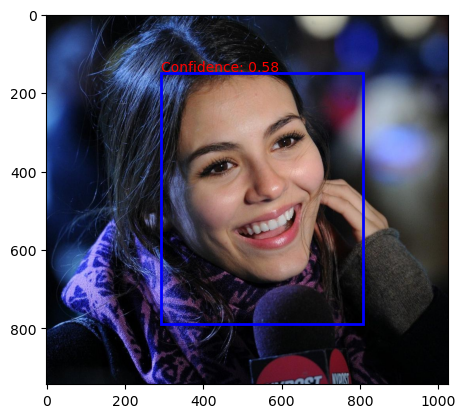

In [100]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img = "0_Parade_Parade_0_1046.jpg"
img_path = "C:\\Code\\Neural Net Projects\\FaceNet\\Dataset\\WIDER_test\\images\\0--Parade\\" + img
image = Image.open(img_path).convert("RGB")
pred_boxes, pred_scores = test_net(image)

fig, ax = plt.subplots(1)
ax.imshow(image)

for box, score in zip(pred_boxes, pred_scores):
    x1, y1, x2, y2 = box.cpu()
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor='blue', facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, f"Confidence: {score:.2f}", color='red')

plt.show()